![](https://www.researchgate.net/profile/Ahmed_Hafaifa/publication/305519718/figure/fig4/AS:391662376374286@1470390995677/Adaptive-fuzzy-neural-network-with-inference-system.png)

Implement ANFIS with tensorflow, number of input variables = 2 (fixed), number of membership fuction = 5 (can change)<br>
In the figure above if the dimmension of input variable = *n_inputs* and the number of membership function per dimmesion is *n_mfs* there're should be *n_inputs $\times$ n_mfs rules*. However, the practice showed that if the number of rules is predefined as *n_rules*, the results were better.


In [1]:
import numpy as np
import tensorflow as tf
import time

/home/hung/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
n_inputs = 2 # number of input variables
n_mfs = 5 # number of membership functions per variable

In [3]:
def tfgaussmf(tensor_x, tensor_mean, tensor_sigma):
    """
    """
    num = -tf.square(tf.subtract(tensor_x, tensor_mean))
    den = 2*tf.square(tensor_sigma)
    return tf.exp(tf.divide(num, den))

In [4]:
# adative fuzzy neural network
# forward pass

# input
inputs = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs), name=None)
# target
targets = tf.placeholder(tf.float32, shape=None)

# parameter - means of membership functions
mu = tf.get_variable(
            name='mu'+str(int(time.time())), 
            shape=[n_inputs,n_mfs],
            initializer=tf.random_normal_initializer(0, 1)
        )

# parameter - sigmas of membership functions
sigma = tf.get_variable(
            name='sigma'+str(int(time.time())), 
            shape=[n_inputs, n_mfs],
            initializer=tf.random_normal_initializer(0, 1)
        )

# transform input
int1 = tf.reshape(inputs, (-1, n_inputs, 1))
int2 = tf.reshape(tf.tile(int1, (1,1,n_mfs)), (-1, n_inputs, n_mfs))

#layer 1 - fuzzification
layer1 = tfgaussmf(int2, mu, sigma)

# layer 2 - rule operation (w_r)
# The following code for layer 2 is ONLY valid for 2D input variable

a0 = layer1[:,0,:]
a1 = layer1[:,1,:]

a00 = tf.expand_dims(tf.tile(tf.expand_dims(a0, 2), [1,1,tf.shape(a1)[1]]),3)
a10 = tf.expand_dims(tf.tile(tf.expand_dims(a1, 1), [1,tf.shape(a0)[1],1]),3)

layer2 = tf.reduce_prod(tf.concat([a00, a10], axis=3),-1)
layer2 = tf.reshape(layer2, (-1, n_mfs**n_inputs))
layer2 = tf.clip_by_value(layer2, 1e-12, 1e12)

# layer 3 - normalization (~w_r)
layer3 = tf.divide(layer2,tf.reduce_sum(layer2, axis=-1, keepdims=True))

# layer 4 - consequent layer
# initialise f
center = tf.get_variable(
            name='center'+str(int(time.time())), 
            shape=[n_mfs**n_inputs],
            initializer=tf.random_normal_initializer(0, 1)
        )

layer4 = tf.multiply(layer3, center)

# layer 5 - predited value
outs = tf.reduce_sum(layer4, axis=-1)

In [5]:
# hyper-parameters for training
# loss
loss = tf.losses.huber_loss(targets, outs)

# optimizer
optimizer = tf.train.AdamOptimizer(
            learning_rate=0.01
        ).minimize(loss)

# trainable parameters
params = tf.trainable_variables()

# number of epochs

epos = 50

In [6]:
# Generate data
# Mackey-Glass series computation
def mackey(n_iters):
    x = np.zeros((n_iters,))
    x[0:30] = 0.23 * np.ones((30,))
    t_s = 30
    for i in range(30, n_iters - 1):
        a = x[i]
        b = x[i - t_s]
        y = ((0.2 * b) / (1 + b ** 10)) + 0.9 * a
        x[i + 1] = y
    return x


# Generate dataset
D = 2  # number of regressors
T = 1  # delay
N = 2000  # Number of points to generate
mg_series = mackey(N)[499:]  # Use last 1500 points
data = np.zeros((N - 500 - T - (D - 1) * T, D))
lbls = np.zeros((N - 500 - T - (D - 1) * T,))

for t in range((D - 1) * T, N - 500 - T):
    data[t - (D - 1) * T, :] = [mg_series[t - T], mg_series[t]]
    ## [mg_series[t - 3 * T], mg_series[t - 2 * T], mg_series[t - T], mg_series[t]]
    lbls[t - (D - 1) * T] = mg_series[t + T]
trnData = data[:lbls.size - round(lbls.size * 0.3), :]
trnLbls = lbls[:lbls.size - round(lbls.size * 0.3)]
chkData = data[lbls.size - round(lbls.size * 0.3):, :]
chkLbls = lbls[lbls.size - round(lbls.size * 0.3):]

In [7]:
# initialize TensorFlow session and trainable parameters
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
# train model with huber_loss
losses = []
for i in range(1000):
    yp, l, _ = sess.run(
                [outs, loss, optimizer], 
                feed_dict={inputs: trnData, targets: trnLbls}
            )
    losses.append(l)

In [9]:
print('Loss on train data:', l)
print('Loss on test data:', sess.run(loss, {inputs: chkData, targets: chkLbls}))

Loss on train data: 0.00079196965
Loss on test data: 0.0008129103


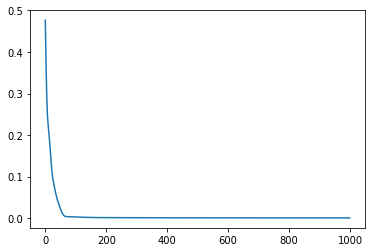

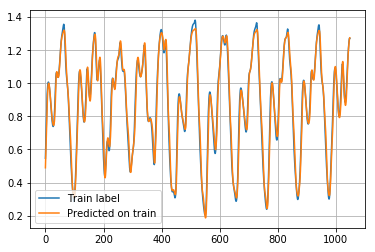

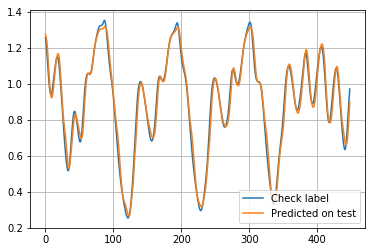

In [10]:
# visulization results
import matplotlib.pyplot as plt
%matplotlib inline

# loss over epoch
plt.figure()
plt.plot(losses)

# Train data: yp & trnLbls
plt.figure()
plt.plot(trnLbls, label='Train label')
plt.plot(yp, label='Predicted on train')
plt.grid(True)
plt.legend()

# Test data
pred_test = sess.run(outs, {inputs: chkData})
plt.figure()
plt.plot(chkLbls, label='Check label')
plt.plot(pred_test, label='Predicted on test')
plt.grid(True)
plt.legend()

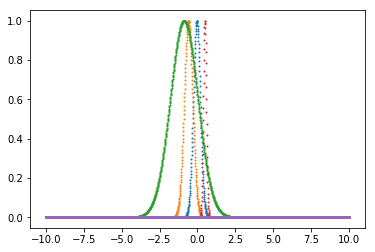

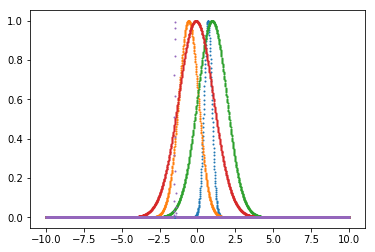

In [11]:
# membership function visulization
xx = np.linspace(start=-10, stop=10, num=2001)
xx = np.stack([xx,xx]).T

layer1_ = sess.run(layer1, {inputs: xx})
layer10 = layer1_[:,0,:]
layer11 = layer1_[:,1,:]
x10 = xx[:,0]
x11 = xx[:,1]

plt.figure()
for i in range(n_mfs):
    fun = layer10[:, i]
    plt.scatter(x=x10, y=fun, s=1)

plt.figure()
for i in range(n_mfs):
    fun = layer11[:, i]
    plt.scatter(x=x11, y=fun, s=1)

In [12]:
# redefine losss
loss = tf.sqrt(tf.losses.mean_squared_error(targets, outs))

In [13]:
# retrain model with RMSE loss
sess.run(tf.global_variables_initializer())
losses = []
# train model
for i in range(1000):
    yp, l, _ = sess.run(
                [outs, loss, optimizer], 
                feed_dict={inputs: trnData, targets: trnLbls}
            )
    losses.append(l)

In [14]:
print('Loss on train data:', l)
print('Loss on test data:', sess.run(loss, {inputs: chkData, targets: chkLbls}))

Loss on train data: 0.011891418
Loss on test data: 0.011452832


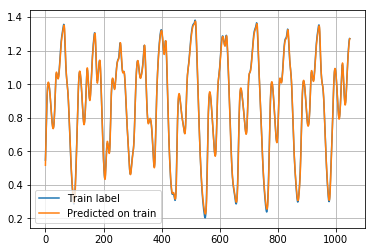

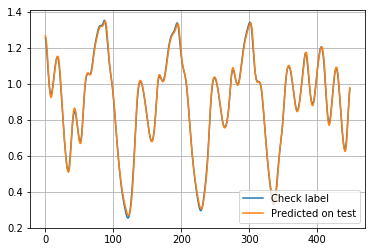

In [15]:
# visulization results
import matplotlib.pyplot as plt
%matplotlib inline

# Train data: yp & trnLbls
plt.figure()
plt.plot(trnLbls, label='Train label')
plt.plot(yp, label='Predicted on train')
plt.grid(True)
plt.legend()

# Test data
pred_test = sess.run(outs, {inputs: chkData})
plt.figure()
plt.plot(chkLbls, label='Check label')
plt.plot(pred_test, label='Predicted on test')
plt.grid(True)
plt.legend()

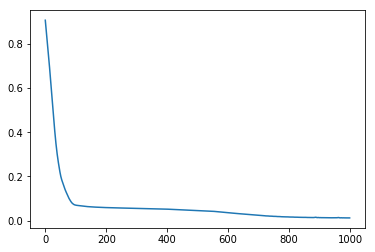

In [16]:
plt.plot(losses)

In [17]:
xx = np.linspace(start=-10, stop=10, num=2001)
xx = np.stack([xx,xx]).T

In [18]:
# membership function visulization
layer1_ = sess.run(layer1, {inputs: xx})
layer10 = layer1_[:,0,:]
layer11 = layer1_[:,1,:]
x10 = xx[:,0]
x11 = xx[:,1]

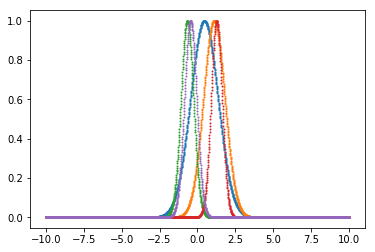

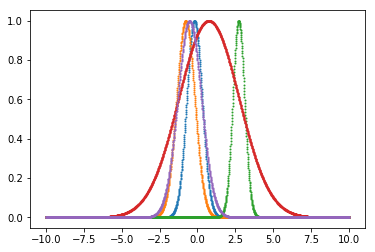

In [19]:
plt.figure()
for i in range(n_mfs):
    fun = layer10[:, i]
    plt.scatter(x=x10, y=fun, s=1)

plt.figure()
for i in range(n_mfs):
    fun = layer11[:, i]
    plt.scatter(x=x11, y=fun, s=1)